In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_selection import chi2, f_classif
import ppscore as pps
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

seed = 36

https://core.ac.uk/download/pdf/55631291.pdf

https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

The data is related with direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to assess if the product (bank term deposit) would be ('yes') or not ('no') subscribed.

1) bank-additional-full.csv with all examples (41188) and 20 inputs, ordered by date (from May 2008 to November 2010), very close to the data analyzed in [Moro et al., 2014]

# Input variables:
### bank client data:
1 - **age** (**numeric**)<br>
2 - **job** : type of job (**categorical**: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')<br>
3 - **marital** : marital status (**categorical**: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)<br>
4 - **education** (**categorical**: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')<br>
5 - **default**: has credit in default? (**categorical**: 'no','yes','unknown')<br>
6 - **housing**: has housing loan? (**categorical**: 'no','yes','unknown')<br>
7 - **loan**: has personal loan? (**categorical**: 'no','yes','unknown')<br>
### related with the last contact of the current campaign:
8 - **contact**: contact communication type (**categorical**: 'cellular','telephone')<br>
9 - **month**: last contact month of year (**categorical**: 'jan', 'feb', 'mar', ..., 'nov', 'dec')<br>
10 - **day_of_week**: last contact day of the week (**categorical**: 'mon','tue','wed','thu','fri')<br>
11 - **duration**: last contact duration, in seconds (**numeric**). **DATA LEAKAGE** Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.<br>
### other attributes:
12 - **campaign**: number of contacts performed during this campaign and for this client (**numeric**, includes last contact)<br>
13 - **pdays**: number of days that passed by after the client was last contacted from a previous campaign (**numeric**; 999 means client was not previously contacted)<br>
14 - **previous**: number of contacts performed before this campaign and for this client (**numeric**)<br>
15 - **poutcome**: outcome of the previous marketing campaign (**categorical**: 'failure','nonexistent','success')<br>
### social and economic context attributes
16 - **emp.var.rate**: employment variation rate - quarterly indicator (**numeric**) Probably: variation of how many people are being hired or fired due to the shifts in the conditions of the economy, - bad, + good<br>
17 - **cons.price.idx**: consumer price index - monthly indicator (**numeric**) Basically inflation, cpi < 100 == prices below base number, cpi > 100 == prices are above base number. Lets divide by 100<br>
18 - **cons.conf.idx**: consumer confidence index - monthly indicator (**numeric**) Measures how confident people are about their expected financial situation. If optimistic, consumers spend more.<br>
19 - **euribor3m**: euribor 3 month rate - daily indicator (**numeric**) Euro Interbank Offered Rate: The Euribor rates are based on the average interest rates at which a large panel of European banks borrow funds from one another. There are different maturities, ranging from one week to one year<br>
20 - **nr.employed**: number of employees - quarterly indicator (**numeric**)<br>

# Target variable:
21 - **y** - has the client subscribed a term deposit? (binary: 'yes','no')

In [2]:
train = pd.read_csv('../data/script_produced/train.csv')

# drop 'duration' column due to data leakage and its 'unrealistic' effect on the target variable
train = train.drop(columns='duration')

In [43]:
train.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,campaign,pdays,previous,poutcome,emp_var_rate,cons_price_idx,cons_conf_idx,euribor3m,nr_employed,y
0,36,management,married,university.degree,no,no,no,cellular,nov,mon,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no
1,49,blue-collar,married,basic.4y,unknown,yes,no,telephone,may,fri,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,41,entrepreneur,single,high.school,no,yes,no,cellular,jul,thu,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
3,41,entrepreneur,divorced,basic.9y,no,yes,no,cellular,jul,thu,1,999,0,nonexistent,1.4,93.918,-42.7,4.958,5228.1,no
4,33,admin.,single,university.degree,no,no,no,cellular,nov,thu,2,999,1,failure,-0.1,93.200,-42.0,4.076,5195.8,no


In [58]:
# training data
print('all train', 3248/(3248+25584))
print('train nonexistent', 2204/(2204+22694))
print('train failure', 409/(409+2562))
print('train success', 635/(635+328))

all train 0.11265260821309656
train nonexistent 0.08852116635874367
train failure 0.13766408616627399
train success 0.6593977154724818


In [59]:
0.6593977154724818/0.11265260821309656

5.853372824046366

In [64]:
print('all test', 1392/(1392+10964))
print('test nonexistent', 937/(937+9728))
print('all failure', 196/(196+1085))
print('all success', 259/(259+151))

all test 0.11265781806409841
test nonexistent 0.08785747773089546
all failure 0.15300546448087432
all success 0.6317073170731707


In [67]:
0.6317073170731707/0.11265781806409841

5.607310064479956

# some feature engineering

In [3]:
# I want 1 to mean neutral, not 100 so I'm dividing by 100
train.cons_price_idx /= 100


# The number of days passed since last contact for a previous campaign appears to be unimportant.
# Also, using 999 to represent NOT previously being contacted implies that they were contacted, just a lot longer ago than the others.
# What appears to be important here is that they were, or were NOT contacted.
# Because of this I'm coding this feature with 1 == contacted, 0 == NOT contacted
train.pdays = train.pdays.apply(lambda x: 0 if x == 999 else 1)

# Looking at multicollinearity

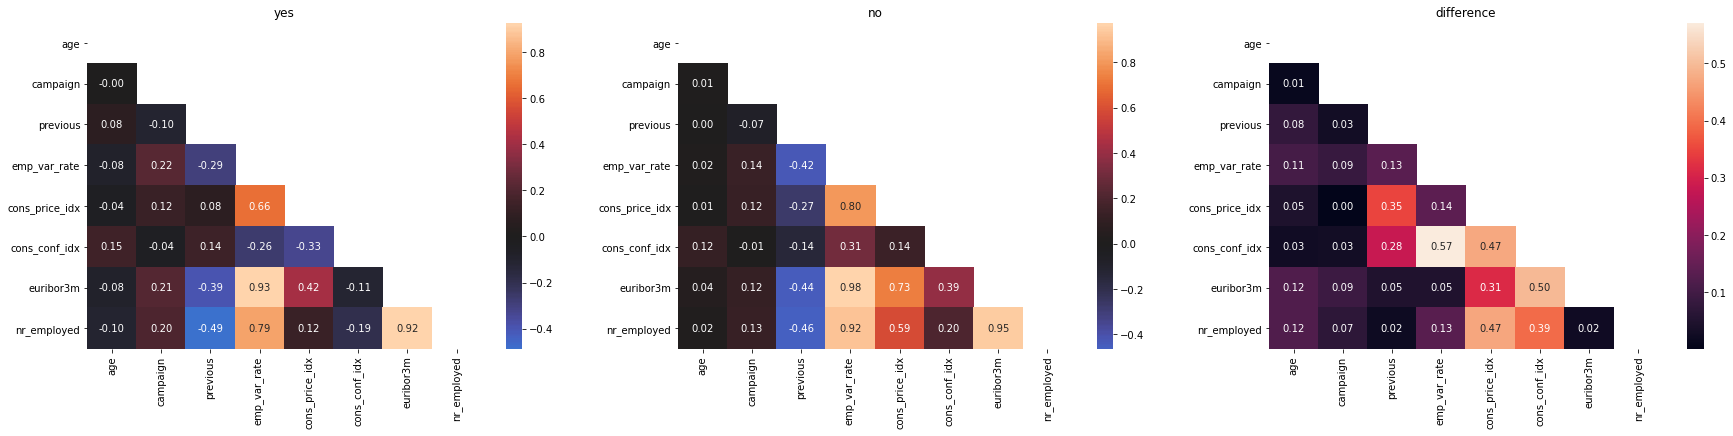

In [4]:
y = train.loc[train.y=='yes', ['age', 'campaign', 'previous', 'emp_var_rate',
                               'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']].corr()
n = train.loc[train.y=='no', ['age', 'campaign', 'previous', 'emp_var_rate',
                              'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed']].corr()
mask_y = np.triu(np.ones_like(y, dtype=bool))
mask_n = np.triu(np.ones_like(n, dtype=bool))

f, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(30,6))
sns.heatmap(y, center=0, mask=mask_y, annot=True, fmt='.2f', annot_kws={'size': 10}, ax=ax1)
ax1.set_title('yes')
sns.heatmap(n, center=0, mask=mask_n, annot=True, fmt='.2f', annot_kws={'size': 10}, ax=ax2)
ax2.set_title('no')
c = (n - y).abs()
mask = np.triu(np.ones_like(c, dtype=bool))
sns.heatmap(c, mask=mask, annot=True, fmt='.2f', annot_kws={'size': 10}, ax=ax3)
ax3.set_title('difference');

nr_employed -> previous **some what**<br>

cons_price_idx -> emp_var_rate **pretty high**<br>
cons_conf_idx -> emp_var_rate **opposite between yes/no**<br>
euribor3m -> emp_var_rate  **highly**<br>
nr_employed -> emp_var_rate **highly**<br>

cons_conf_idx -> cons_price_idx **opposite between yes/no**<br>
euribor3m -> cons_price_idx **pretty high, but also different between yes/no**<br>
nr_employed -> cons_price_idx **kind of high, but very different between yes/no**<br>

euribor3m -> cons_conf_idx **very different between different yes/no**<br>
nr_employed -> cons_conf_idx **pretty different between different yes/no**<br>

nr_employed -> euribor3m **highly**<br>

### look at categorical features with chi-square statistic

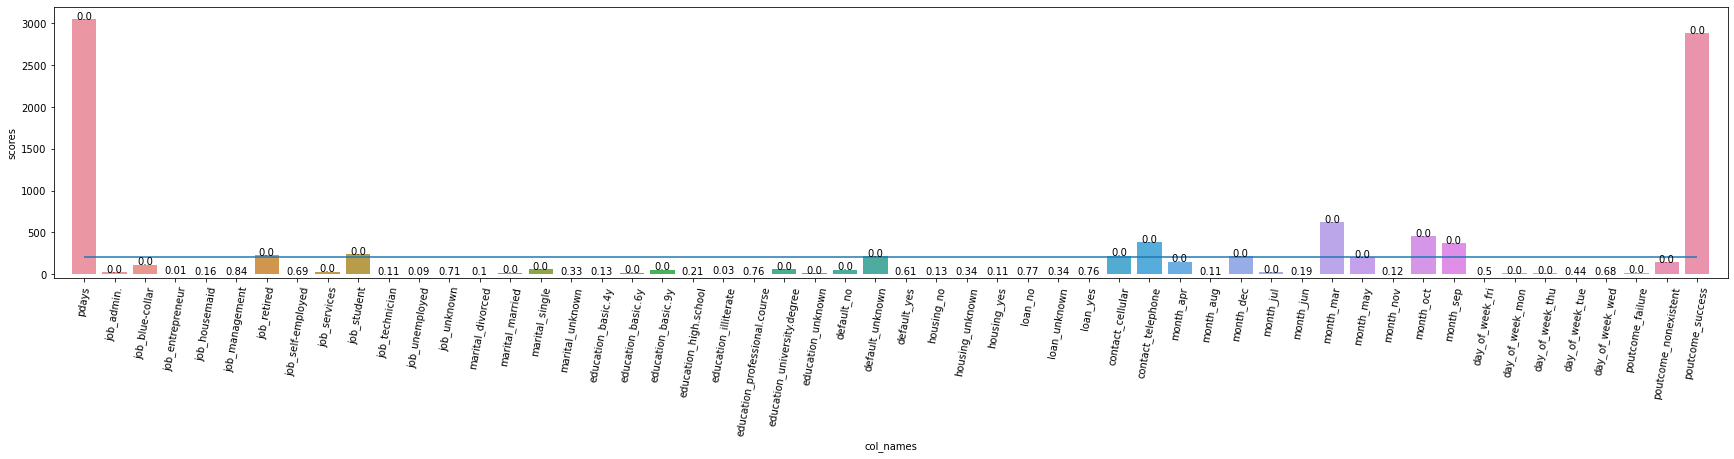

In [5]:
cat_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'pdays', 'y']
X = train.loc[:, cat_features]

y = X.y
X = X.drop(columns='y')

X = pd.get_dummies(X)

chi_scores, p_values = chi2(X, y)

sc = pd.DataFrame([[s, p, X.columns[i]] for i, (s, p) in enumerate(zip(chi_scores, p_values))], columns=['scores', 'p_values', 'col_names'])
sc.p_values = sc.p_values.round(2)

f, ax = plt.subplots(figsize=(30,5))
sns.barplot(data=sc, x='col_names', y='scores', ax=ax)
for row in sc.itertuples():
    ax.text(row.Index, row.scores, row.p_values, color='black', ha="center")
ax.hlines(sc.scores.quantile(.8), xmin=0, xmax=53)
ax.tick_params(axis='x', labelrotation=80)
ax.set_ylim(-50, 3200)
ax.set_xlim(-1, 54);

The chi-squared tests tell us if there is a relationship between the feature and the target variable that is likely to reflect a real association. Or put another way, it tells us if there is a difference between the two variables.

The top 20% (p_values < .05) from the test are:
- pdays
- job: retired, student
- default: unknown
- contact: cellular, telephone
- month: dec, mar, may, oct, sep
- poutcome: success

### look at continuous features with ANOVA F-value

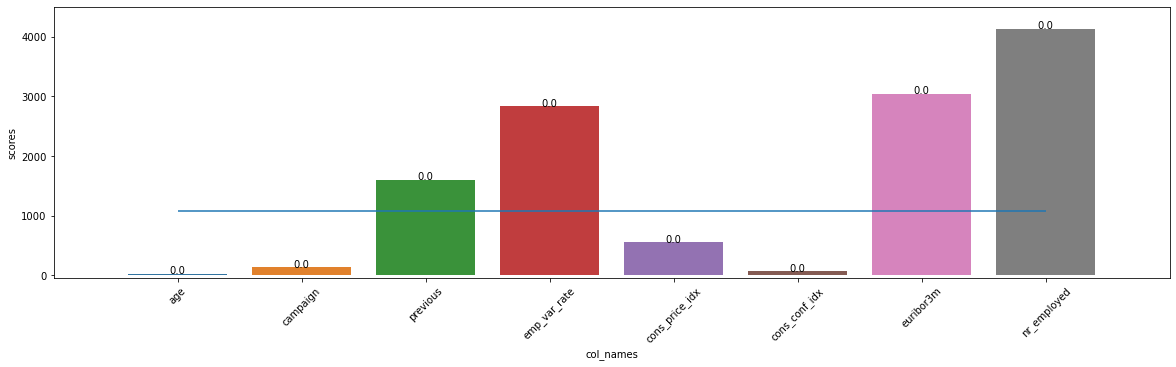

In [6]:
con_features = ['age', 'campaign', 'previous', 'emp_var_rate', 'cons_price_idx', 'cons_conf_idx', 'euribor3m', 'nr_employed', 'y']
X = train.loc[:, con_features]

y = X.y
X = X.drop(columns='y')

f_scores, p_values = f_classif(X, y)

sc = pd.DataFrame([[s, p, X.columns[i]] for i, (s, p) in enumerate(zip(f_scores, p_values))], columns=['scores', 'p_values', 'col_names'])
sc.p_values = sc.p_values.round(2)

f, ax = plt.subplots(figsize=(20,5))
sns.barplot(data=sc, x='col_names', y='scores', ax=ax)
for row in sc.itertuples():
    ax.text(row.Index, row.scores, row.p_values, color='black', ha="center")
ax.hlines(sc.scores.quantile(.5), xmin=0, xmax=7)
ax.tick_params(axis='x', labelrotation=45)
ax.set_ylim(-50, 4500)
ax.set_xlim(-1, 8);
# ax.set_xlim(-1, 10);

The top 50% (p_values < .05) from the test are:
- previous
- emp_var_rate
- euribor3m
- nr_employed

### look at the Predictive Power Score (PPS) for all features

https://github.com/8080labs/ppscore

The score ranges from 0 (no predictive power) to 1 (perfect predictive power)

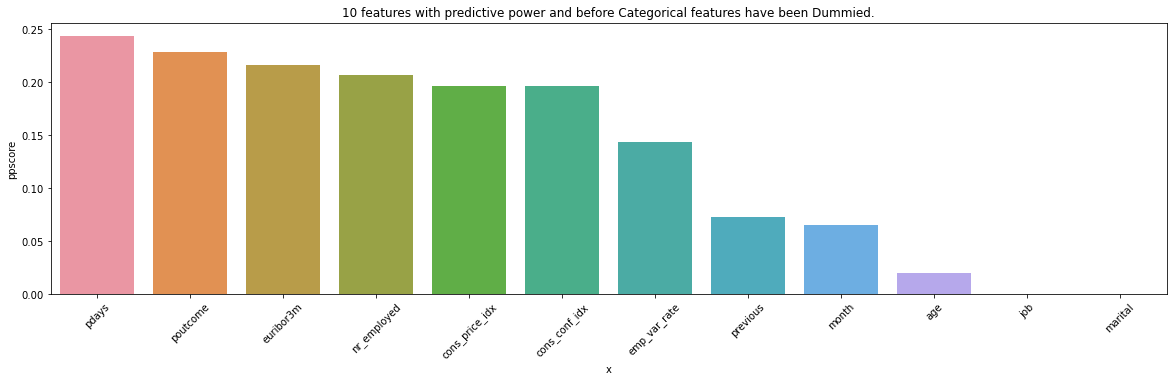

In [7]:
rawer = pps.predictors(train, 'y').loc[:11, ['x', 'ppscore', 'metric']]

f, ax = plt.subplots(figsize=(20,5))
sns.barplot(data=rawer, x='x', y='ppscore', ax=ax)
ax.tick_params(axis='x', labelrotation=45)
ax.set_title('10 features with predictive power and before Categorical features have been Dummied.');

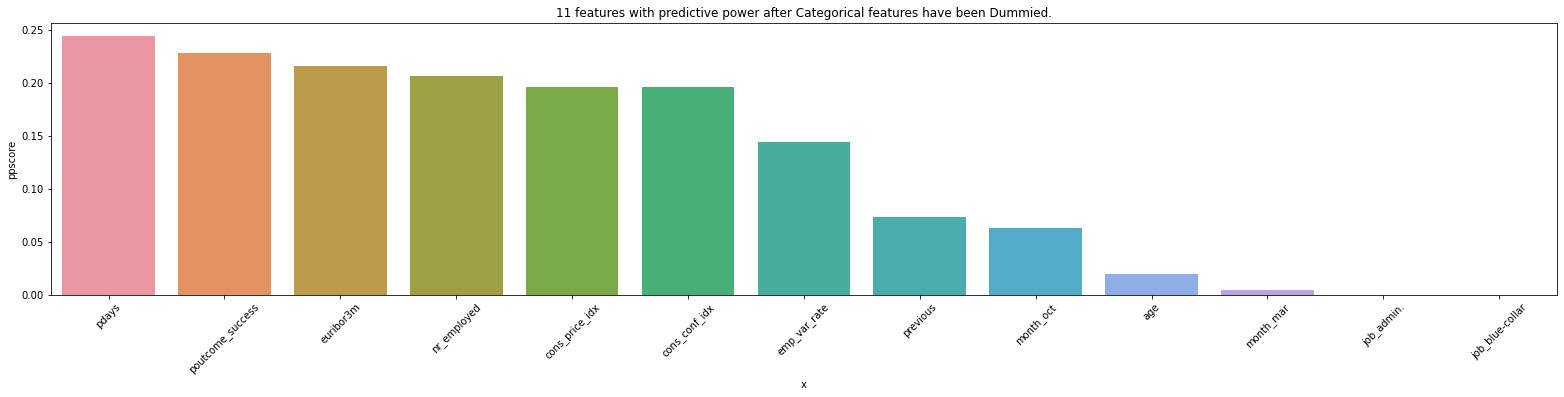

In [8]:
X = train.loc[:, cat_features]
X = X.drop(columns='y')
X = pd.get_dummies(X)
X = pd.concat([X, train.loc[:, con_features]], axis=1)

dummied = pps.predictors(X, 'y').loc[:12, ['x', 'ppscore', 'metric']]

f, ax = plt.subplots(figsize=(27,5))
sns.barplot(data=dummied, x='x', y='ppscore', ax=ax)
ax.tick_params(axis='x', labelrotation=45)
ax.set_title('11 features with predictive power after Categorical features have been Dummied.');

Features that show up in both cases:
- pdays
- poutcome: success
- euribor3m, pdays, nr_employed, cons_price_idx, cons_conf_idx, emp_var_rate, previous **continuous**
- month: oct, mar **kind of**
- age **continuous**

## Features we will consider for the model, some of which will probably get trashed

[<br>
- 'job_retired',<br>
- 'job_student',<br>
- 'default_unknown',<br>
- 'contact_cellular',<br>
- 'contact_telephone',<br>
- 'month_dec',<br>
- 'month_mar',        # **<br>
- 'month_may',<br>
- 'month_oct',        # **<br>
- 'month_sep',<br>
- 'poutcome_success', # **<br>
- 'pdays',            # **<br>
- 'previous',         # **<br>
- 'emp_var_rate',     # **<br>
- 'euribor3m',        # **<br>
- 'nr_employed',      # **<br><br>
- 'cons_price_idx',   # -----<br>
- 'cons_conf_idx',    # -----<br><br>
]

## watch out for multicollinearity

nr_employed -> previous **some what**<br>

cons_price_idx -> emp_var_rate **pretty high**<br>
cons_conf_idx -> emp_var_rate **opposite between yes/no**<br>
euribor3m -> emp_var_rate  **highly**<br>
nr_employed -> emp_var_rate **highly**<br>

cons_conf_idx -> cons_price_idx **opposite between yes/no**<br>
euribor3m -> cons_price_idx **pretty high, but also different between yes/no**<br>
nr_employed -> cons_price_idx **kind of high, but very different between yes/no**<br>

euribor3m -> cons_conf_idx **very different between different yes/no**<br>
nr_employed -> cons_conf_idx **pretty different between different yes/no**<br>

nr_employed -> euribor3m **highly**<br>

## save new csv files

In [9]:
features = [
    'y',
    'job_retired',
    'job_student',
    'default_unknown',
    'contact_cellular',
    'contact_telephone',
    'month_dec',
    'month_mar',
    'month_may',
    'month_oct',
    'month_sep',
    'poutcome_success',
    'pdays',
    'previous',
    'emp_var_rate',
    'euribor3m',
    'nr_employed',
    'cons_price_idx',
    'cons_conf_idx',
]
important_features_training = X.loc[:, features]

# read in testing data JUST to feature engineer and select columns
test = pd.read_csv('../data/script_produced/test.csv')

test.cons_price_idx /= 100
test.pdays = test.pdays.apply(lambda x: 0 if x == 999 else 1)

X_test = test.loc[:, cat_features]
X_test = X_test.drop(columns='y')
X_test = pd.get_dummies(X_test)
X_test = pd.concat([X_test, test.loc[:, con_features]], axis=1)

important_features_testing = X_test.loc[:, features]

important_features_training.shape, important_features_testing.shape

((28832, 19), (12356, 19))

In [10]:
# important_features_training.to_csv('../data/notebook_produced_2/train.csv', index=False)
# important_features_testing.to_csv('../data/notebook_produced_2/test.csv', index=False)